In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_kernels
from scipy.optimize import minimize
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

class SyntheticOPEEnvironment:
    def __init__(self, d=5, seed=0):
        self.d = d
        np.random.seed(seed)
        self.beta = np.linspace(0.1, 0.5, d)

    def logging_policy(self, X):
        logits = -2 * (X @ self.beta)  # opposite of pi
        probs = 1 / (1 + np.exp(-logits))
        return np.random.binomial(1, probs)


    def target_policy(self, X):
        logits = X @ self.beta
        probs = 1 / (1 + np.exp(-logits))
        return np.random.binomial(1, probs)

    def true_outcome(self, X, A):
        return (X @ self.beta) + 2.0 * (A ** 2) + 0.1 * np.random.randn(len(X))

    def sample(self, n, policy="logging"):
        X = np.random.randn(n, self.d)
        if policy == "logging":
            A = self.logging_policy(X)
        elif policy == "target":
            A = self.target_policy(X)
        else:
            raise ValueError("Unknown policy type.")
        Y = self.true_outcome(X, A)
        return X, A, Y


In [33]:
def compute_weights(A, X, pi_func, pi0_func):
    """
    A: array of actions taken (0 or 1)
    X: covariates
    pi_func: target policy, returns P(a=1 | x)
    pi0_func: logging policy, returns P(a=1 | x)
    """
    p_pi = pi_func(X)
    p_pi0 = pi0_func(X)
    
    # Ensure clipping to avoid divide-by-zero
    eps = 1e-6
    p_pi = np.clip(p_pi, eps, 1 - eps)
    p_pi0 = np.clip(p_pi0, eps, 1 - eps)

    # Importance weights for binary treatment
    weights = (A * p_pi / p_pi0) + ((1 - A) * (1 - p_pi) / (1 - p_pi0))
    return weights

def pi0_func(X):
    return np.full(X.shape[0], 0.5)  # uniform logging

def pi_func(X):
    logits = 4 * (X @ np.linspace(0.1, 0.5, X.shape[1]))  # increase separation
    return 1 / (1 + np.exp(-logits))

def pi0_proba(a, X):
    """
    Logging policy: P(a=1|x) = sigmoid(-2 * x · beta), P(a=0|x) = 1 - P(a=1|x)
    """
    logits = -2 * (X @ np.linspace(0.1, 0.5, X.shape[1]))
    probs = 1 / (1 + np.exp(-logits))  # P(a=1 | x)
    a = np.asarray(a)
    return probs * (a == 1) + (1 - probs) * (a == 0)



def pi_proba(a, X):
    """
    Target policy: logistic over X @ beta, returns pi(a|x)
    """
    logits = 4 * (X @ np.linspace(0.1, 0.5, X.shape[1]))
    probs = 1 / (1 + np.exp(-logits))  # P(a=1|x)
    a = np.asarray(a)
    return probs * (a == 1) + (1 - probs) * (a == 0)

def importance_weights(A, X, pi, pi0, eps=1e-8):
    """
    Compute importance weights w = pi(a|x) / pi0(a|x)

    Parameters
    ----------
    A : np.ndarray of shape (n,)
        Actions taken (can be discrete or continuous)
    X : np.ndarray of shape (n, d)
        Contexts
    pi : callable
        Target policy. Should return pi(a|x) — either probability mass or density.
    pi0 : callable
        Logging policy. Same interface as pi.
    eps : float
        Clipping constant to avoid division by zero or instability.

    Returns
    -------
    w : np.ndarray of shape (n,)
        Importance sampling weights.
    """
    numer = pi(A, X)
    denom = pi0(A, X)
    
    # clip to avoid division by zero or exploding weights
    numer = np.clip(numer, eps, None)
    denom = np.clip(denom, eps, None)

    return numer / denom

In [34]:
env = SyntheticOPEEnvironment()

# Step 1: generate logging data
X_log, A_log, Y_log = env.sample(n=500, policy="logging")

# Step 2: simulate counterfactual data under target policy
X_tgt, A_tgt, Y_tgt = env.sample(n=500, policy="target")

def find_best_params(
    X_log, A_log, Y_log, reg_grid=[1e1, 1e0, 0.1, 1e-2, 1e-3, 1e-4], num_cv=3
):
    kr = GridSearchCV(
        KernelRidge(kernel="rbf", gamma=0.1),
        cv=num_cv,
        param_grid={"alpha": reg_grid},
    )
    features = np.concatenate([X_log, A_log.reshape(-1, 1)], axis=1)
    kr.fit(features, Y_log)
    reg_param = kr.best_params_["alpha"]
    return reg_param

selected_reg_lambda = find_best_params(X_log, A_log, Y_log)

def plugin_embedding_pi(Y,
    X,
    logging_T,
    pi_samples):

    N = len(Y)

    sigmaKX = np.median(pairwise_distances(X, X, metric="euclidean")) ** 2
    sigmaKT = 0.5
    reg_lambda = selected_reg_lambda

    KX = pairwise_kernels(X, metric="rbf", gamma=1.0 / (2* sigmaKX))
    KT = pairwise_kernels(logging_T[:, None], metric="rbf", gamma=1.0 / (2* sigmaKT))
    KT_pi = pairwise_kernels(logging_T[:, None], pi_samples[:, None], metric="rbf", gamma=1.0 / (2* sigmaKT))

    mu_pi = np.linalg.solve(
        np.multiply(KX, KT) + reg_lambda * np.eye(N),
        np.multiply(KX, KT_pi)
    )

    phi = mu_pi 
    return phi

def dr_embedding_pi(
    Y,
    X,
    logging_T,
    w_pi,
    pi_samples,
):
    """
    Construct the RKHS embedding chi_hat(pi) via DR-style estimator:
    chi_hat(pi) = mu_pi - mu_log + (w_pi - 1)(Id - mu_log)
    """
    N = len(Y)

    sigmaKX = np.median(pairwise_distances(X, X, metric="euclidean")) ** 2 + 1e-8
    sigmaKT = 0.5
    reg_lambda = selected_reg_lambda

    KX = pairwise_kernels(X, metric="rbf", gamma=1.0 / (2* sigmaKX))
    KT = pairwise_kernels(logging_T[:, None], metric="rbf", gamma=1.0 / (2* sigmaKT))
    KT_pi = pairwise_kernels(logging_T[:, None], pi_samples[:, None], metric="rbf", gamma=1.0 / (2* sigmaKT))

    mu_log = np.linalg.solve(
        np.multiply(KX, KT) + reg_lambda * np.eye(N),
        np.multiply(KX, KT)
    )
    mu_pi = np.linalg.solve(
        np.multiply(KX, KT) + reg_lambda * np.eye(N),
        np.multiply(KX, KT_pi)
    )

    # DR term
    correction = w_pi[:, None]*(np.eye(N) - mu_log)
    phi = mu_pi + correction
    return phi

sigma = np.median(pairwise_distances(Y_log[:, None], Y_log[:, None])) ** 2

embedding_plug_in = plugin_embedding_pi(Y_log, X_log, A_log,
    A_tgt)
w_pi = importance_weights(A_log, X_log, pi_proba, pi0_proba)
embedding_dr = dr_embedding_pi(Y_log, X_log, A_log,
    w_pi,
    A_tgt,
)

# --- Kernel herding from CME embedding ---

def kernel_herding(Y_support, weights, sigma, num_samples):
    y0 = np.random.randn()
    res = minimize(
        lambda y: -np.mean(np.dot(weights.T, pairwise_kernels(Y_support.reshape(-1, 1), np.atleast_2d(y), metric="rbf", gamma=1.0 / (2 * sigma)))),
        y0,
        method="CG",
        options={"gtol": 1e-6, "disp": False},
    )
    yt = res.x.ravel()[0]
    samples = [yt]
    for t in range(2, num_samples + 1):
        yt_hist = np.array(samples)
        res = minimize(
            lambda y: -np.mean(np.dot(weights.T, pairwise_kernels(Y_support.reshape(-1, 1), np.atleast_2d(y), metric="rbf", gamma=1.0 / (2 * sigma))))
            + np.mean(pairwise_kernels(yt_hist.reshape(-1, 1), np.atleast_2d(y), metric="rbf", gamma=1.0 / (2 * sigma))),
            y0,
            method="CG",
            options={"gtol": 1e-6, "disp": False},
        )
        yt = res.x.ravel()[0]
        samples.append(yt)
    return np.array(samples)

Y_herded_plug_in_cme = kernel_herding(Y_log, embedding_plug_in, sigma=sigma, num_samples=500)

Y_herded_dr_cme = kernel_herding(Y_log, embedding_dr, sigma=sigma, num_samples=500)


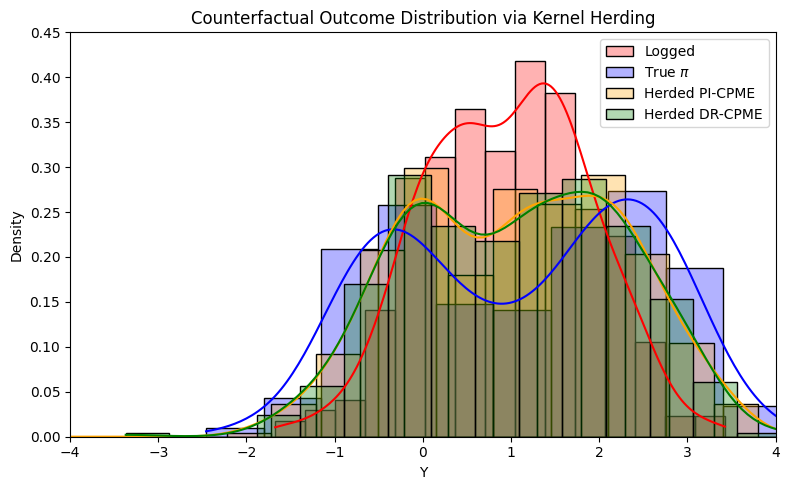

In [35]:
# --- Plot comparison ---

def plot_herding_vs_true(Y_log, Y_tgt, Y_herded_dr_cme, Y_herded_plug_in_cme):
    plt.figure(figsize=(8, 5))
    sns.histplot(Y_log, color="red", kde=True, stat="density", label="Logged", alpha=0.3)
    sns.histplot(Y_tgt, color="blue", kde=True, stat="density", label="True $\pi$", alpha=0.3)
    # sns.histplot(Y_herded, color="green", kde=True, stat="density", label="Herded CME", alpha=0.3)
    sns.histplot(Y_herded_plug_in_cme, color="orange", kde=True, stat="density", label="Herded PI-CPME", alpha=0.3)
    sns.histplot(Y_herded_dr_cme, color="green", kde=True, stat="density", label="Herded DR-CPME", alpha=0.3)
    plt.xlim([-4, 4])
    plt.xlabel("Y")
    plt.ylabel("Density")
    plt.ylim(0, 0.45)
    plt.legend()
    plt.title("Counterfactual Outcome Distribution via Kernel Herding")
    plt.tight_layout()
    plt.show()

plot_herding_vs_true(Y_log, Y_tgt, Y_herded_dr_cme, Y_herded_plug_in_cme)

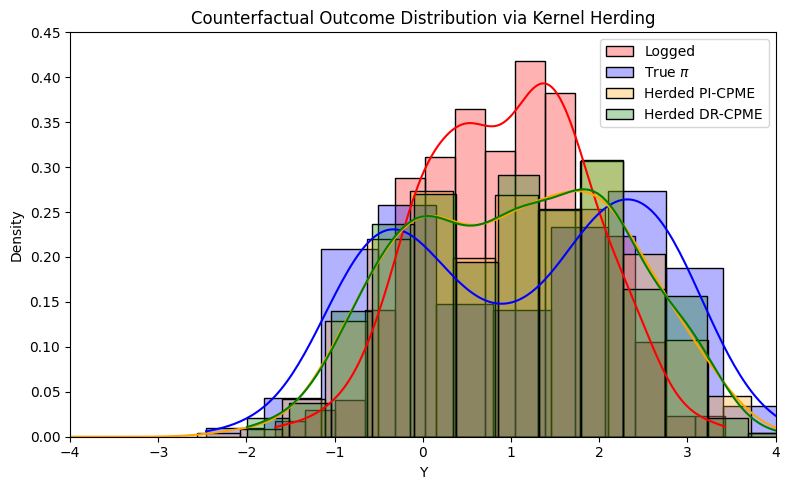

In [25]:
# --- Plot comparison ---

def plot_herding_vs_true(Y_log, Y_tgt, Y_herded_dr_cme, Y_herded_plug_in_cme):
    plt.figure(figsize=(8, 5))
    sns.histplot(Y_log, color="red", kde=True, stat="density", label="Logged", alpha=0.3)
    sns.histplot(Y_tgt, color="blue", kde=True, stat="density", label="True $\pi$", alpha=0.3)
    # sns.histplot(Y_herded, color="green", kde=True, stat="density", label="Herded CME", alpha=0.3)
    sns.histplot(Y_herded_plug_in_cme, color="orange", kde=True, stat="density", label="Herded PI-CPME", alpha=0.3)
    sns.histplot(Y_herded_dr_cme, color="green", kde=True, stat="density", label="Herded DR-CPME", alpha=0.3)
    plt.xlim([-4, 4])
    plt.xlabel("Y")
    plt.ylabel("Density")
    plt.ylim(0, 0.45)
    plt.legend()
    plt.title("Counterfactual Outcome Distribution via Kernel Herding")
    plt.tight_layout()
    plt.show()

plot_herding_vs_true(Y_log, Y_tgt, Y_herded_dr_cme, Y_herded_plug_in_cme)

In [29]:
from scipy.stats import wasserstein_distance
d_dr_cme = wasserstein_distance(Y_herded_dr_cme, Y_tgt)
d_pi_cme = wasserstein_distance(Y_herded_plug_in_cme, Y_tgt)
d_dr_cme, d_pi_cme

(0.26937344763281384, 0.2724031389751794)

In [30]:
def mmd2_unbiased(X, Y, kernel, gamma):
    K_XX = pairwise_kernels(X[:, None], X[:, None], metric=kernel, gamma=gamma)
    K_YY = pairwise_kernels(Y[:, None], Y[:, None], metric=kernel, gamma=gamma)
    K_XY = pairwise_kernels(X[:, None], Y[:, None], metric=kernel, gamma=gamma)
    n = len(X)
    m = len(Y)
    return (
        (K_XX.sum() - np.trace(K_XX)) / (n * (n - 1))
        + (K_YY.sum() - np.trace(K_YY)) / (m * (m - 1))
        - 2 * K_XY.mean()
    )
mmd_dr_cme = mmd2_unbiased(Y_herded_dr_cme, Y_tgt, 'rbf', sigma)
mmd_pi_cme = mmd2_unbiased(Y_herded_plug_in_cme, Y_tgt, 'rbf', sigma)

In [31]:
mmd_dr_cme, mmd_pi_cme

(0.02449451429142535, 0.024523718366087688)